# Goal

We're going to test **Xavier** and **Kaiming** initializations on two different problems.  
These initialization methods are optimized for **different activation functions**:

| Weights Initialization | Recommended Activation | Best Distribution |
| ----------------------- | ---------------------- | ----------------- |
| **Kaiming (He)**        | ReLU, LeakyReLU, GELU  | **Normal**        |
| **Xavier (Glorot)**     | tanh, sigmoid          | **Uniform**       |

## Experiment Setup

We will build **two neural network models**, each trained on a different problem and using the activation/init pair that best fits it.

**Model 1 — ReLU Network (Kaiming Normal)**

* **Task:** Nonlinear regression (continuous output)  
* **Dataset:** 1D sine wave regression  
* **Activation:** ReLU  
* **Initialization:** Kaiming Normal
* **Goal:** Test how Kaiming handles gradient flow and variance preservation in a ReLU-based regression model.

**Model 2 — tanh Network (Xavier Uniform)**

* **Task:** Binary classification.
* **Dataset:** make_moons() from sklearn.datasets (nonlinear, 2D)
* **Activation:** tanh
* **Initialization:** Xavier Uniform
* **Goal:** Verify if Xavier stabilizes training with saturating activations like tanh.

# Model 1 - Regression + ReLU + Kaiming Normal

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## Data

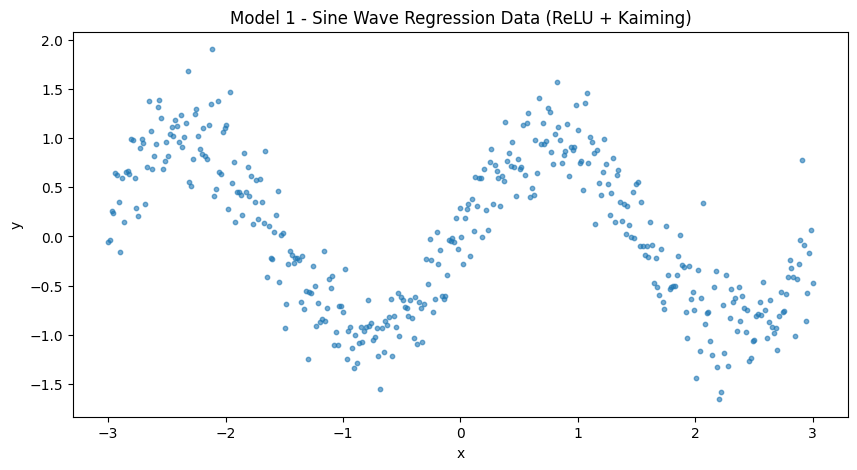

In [160]:
plt.figure(figsize=(10,5))

torch.manual_seed(0)
X = torch.linspace(-3, 3, 400).unsqueeze(1)
y = torch.sin(2 * X) + 0.3 * torch.randn_like(X)

plt.scatter(X.numpy(), y.numpy(), s=10, alpha=0.6)
plt.title('Model 1 - Sine Wave Regression Data (ReLU + Kaiming)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


Standarize

In [161]:
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

## Split

In [162]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0], shuffle = False)

/tmp/ipython-input-597909178.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).float()
/tmp/ipython-input-597909178.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


## Model

In [163]:
def CreateNet():

    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(1, 64)
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 64)
            self.output = nn.Linear(64, 1)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    net = Net()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_fn, optimizer

In [164]:
net, loss_fn, optimizer = CreateNet()
net

Net(
  (input): Linear(in_features=1, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

## Weights Inits

In [165]:
kaiming_weights = torch.tensor([])
xavier_weights = torch.tensor([])

# Kaiming Normal Distribution
kaiming_net, kaiming_loss_fn, kaiming_optimizer = CreateNet()
for name, params in kaiming_net.named_parameters():
  if 'weight' in name:
    nn.init.kaiming_normal_(params, nonlinearity = 'relu')
    kaiming_weights = torch.cat((kaiming_weights, params.data.flatten()), axis = 0)

# Xavier Uniform Distribution
xavier_net, xavier_loss_fn, xavier_optimizer = CreateNet()
for name, params in xavier_net.named_parameters():
  if 'weight' in name:
    nn.init.xavier_uniform_(params)
    xavier_weights = torch.cat((xavier_weights, params.data.flatten()), axis = 0)

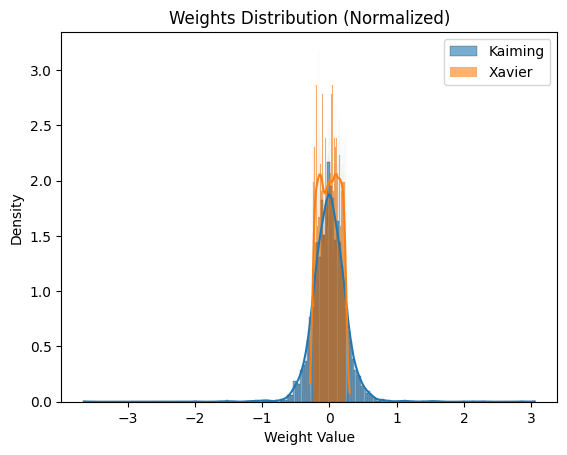

In [166]:
sns.histplot(kaiming_weights, bins=200, label='Kaiming', kde=True, stat='density', alpha=0.6)
sns.histplot(xavier_weights, bins=200, label='Xavier', kde=True, stat='density', alpha=0.6)
plt.legend()
plt.title('Weights Distribution (Normalized)')
plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.show()

## Train

In [167]:
def ModelTrain(net, loss_fn, optimizer, epochs, verbose):

    losses = torch.zeros(epochs)
    train_mae = []
    test_mae = []

    for epoch in range(epochs):
        net.train()

        batch_loss = []
        batch_mae = []

        for X, y in train_dataloader:
            y_hat = net(X)
            loss = loss_fn(y_hat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # track batch loss
            batch_loss.append(loss.item())

            # compute MAE for this batch
            mae = torch.mean(torch.abs(y_hat - y)).item()
            batch_mae.append(mae)

        # epoch-level metrics
        train_mae.append(np.mean(batch_mae))
        losses[epoch] = np.mean(batch_loss)

        # test MAE
        net.eval()
        X_test, y_test = next(iter(test_dataloader))
        with torch.no_grad():
            y_pred = net(X_test)
            test_mae_value = torch.mean(torch.abs(y_pred - y_test)).item()
        test_mae.append(test_mae_value)

        if verbose and epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train MAE: {train_mae[-1]:.4f} | Test MAE: {test_mae[-1]:.4f} | Loss: {losses[epoch]:.4f}")

    return train_mae, test_mae, losses

### Kaiming

In [168]:
kaiming_train_maes, kaiming_test_maes, kaiming_losses = ModelTrain(kaiming_net, kaiming_loss_fn, kaiming_optimizer, epochs = 200, verbose = True)

Epoch: 0 | Train MAE: 0.8030 | Test MAE: 0.6586 | Loss: 0.9929
Epoch: 10 | Train MAE: 0.3321 | Test MAE: 0.3903 | Loss: 0.1943
Epoch: 20 | Train MAE: 0.3281 | Test MAE: 0.3860 | Loss: 0.1826
Epoch: 30 | Train MAE: 0.3293 | Test MAE: 0.3811 | Loss: 0.1813
Epoch: 40 | Train MAE: 0.3094 | Test MAE: 0.3605 | Loss: 0.1572
Epoch: 50 | Train MAE: 0.2994 | Test MAE: 0.3540 | Loss: 0.1465
Epoch: 60 | Train MAE: 0.3017 | Test MAE: 0.3604 | Loss: 0.1493
Epoch: 70 | Train MAE: 0.3038 | Test MAE: 0.3569 | Loss: 0.1513
Epoch: 80 | Train MAE: 0.2957 | Test MAE: 0.3493 | Loss: 0.1415
Epoch: 90 | Train MAE: 0.2962 | Test MAE: 0.3553 | Loss: 0.1413
Epoch: 100 | Train MAE: 0.3063 | Test MAE: 0.3614 | Loss: 0.1490
Epoch: 110 | Train MAE: 0.3017 | Test MAE: 0.3583 | Loss: 0.1479
Epoch: 120 | Train MAE: 0.3002 | Test MAE: 0.3563 | Loss: 0.1445
Epoch: 130 | Train MAE: 0.2992 | Test MAE: 0.3621 | Loss: 0.1438
Epoch: 140 | Train MAE: 0.3011 | Test MAE: 0.3635 | Loss: 0.1465
Epoch: 150 | Train MAE: 0.2964 | Tes

### Xavier

In [169]:
xavier_train_maes, xavier_test_maes, xaveir_losses = ModelTrain(xavier_net, xavier_loss_fn, xavier_optimizer, epochs = 200, verbose = True)

Epoch: 0 | Train MAE: 0.8737 | Test MAE: 0.8984 | Loss: 1.0135
Epoch: 10 | Train MAE: 0.5244 | Test MAE: 0.6252 | Loss: 0.4120
Epoch: 20 | Train MAE: 0.3340 | Test MAE: 0.4111 | Loss: 0.1918
Epoch: 30 | Train MAE: 0.3243 | Test MAE: 0.3856 | Loss: 0.1827
Epoch: 40 | Train MAE: 0.3394 | Test MAE: 0.3806 | Loss: 0.1937
Epoch: 50 | Train MAE: 0.3253 | Test MAE: 0.3935 | Loss: 0.1704
Epoch: 60 | Train MAE: 0.3132 | Test MAE: 0.3786 | Loss: 0.1637
Epoch: 70 | Train MAE: 0.3184 | Test MAE: 0.3637 | Loss: 0.1681
Epoch: 80 | Train MAE: 0.3156 | Test MAE: 0.3787 | Loss: 0.1631
Epoch: 90 | Train MAE: 0.3036 | Test MAE: 0.3678 | Loss: 0.1532
Epoch: 100 | Train MAE: 0.3143 | Test MAE: 0.3613 | Loss: 0.1618
Epoch: 110 | Train MAE: 0.2916 | Test MAE: 0.3716 | Loss: 0.1401
Epoch: 120 | Train MAE: 0.2992 | Test MAE: 0.3541 | Loss: 0.1460
Epoch: 130 | Train MAE: 0.2937 | Test MAE: 0.3569 | Loss: 0.1403
Epoch: 140 | Train MAE: 0.2941 | Test MAE: 0.3675 | Loss: 0.1444
Epoch: 150 | Train MAE: 0.2934 | Tes

## Plot

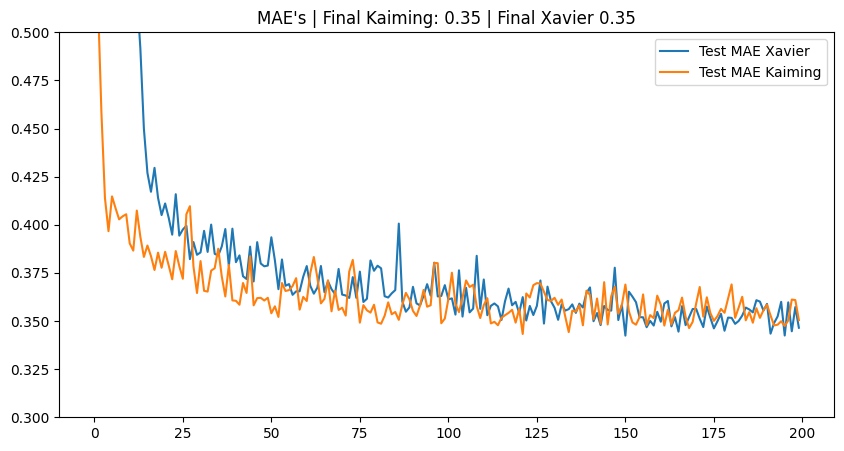

In [182]:
# plt.plot(xavier_train_maes, label = 'Train Xavier')
# plt.plot(kaiming_train_maes, label = 'Train Kaiming')
plt.figure(figsize = (10, 5))
plt.plot(xavier_test_maes, label = 'Test MAE Xavier')
plt.plot(kaiming_test_maes, label = 'Test MAE Kaiming')
plt.title(f'MAE\'s | Final Kaiming: {kaiming_test_maes[-1]:.2f} | Final Xavier {xavier_test_maes[-1]:.2f}')
plt.legend()
plt.ylim([0.3,.5])
plt.show()

## Conclusion

The Final MAE is practically the same for Kaiming and Xavier Initializations. However, we can see that Kaiming converge faster by ~10 epochs. That shows Kaiming is better adjusted for ReLU activation function which we've used in our regression problem.

# Model 2 — Classification + Tanh + Xavier

## Data

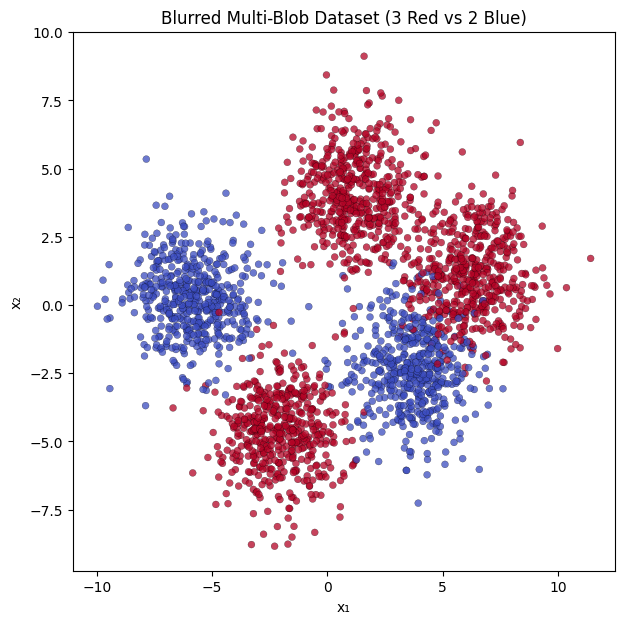

In [286]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def make_blurred_blobs(n_samples=2500, centers_per_class=(3,2), noise=1.4, random_state=42):
    np.random.seed(random_state)

    # 3 centra dla klasy 1 (czerwone)
    centers_class1 = np.array([
        [3, 3],
        [6, -2],
        [-4, -3]
    ])

    # 2 centra dla klasy 0 (niebieskie)
    centers_class0 = np.array([
        [-5, 3],
        [2, -4]
    ])

    centers = np.vstack([centers_class0, centers_class1])

    X_np, y_np = make_blobs(
        n_samples=n_samples,
        centers=centers,
        cluster_std=noise,  # <–– większy rozrzut wokół centrów
        random_state=random_state
    )

    # pierwsze 2 centra = klasa 0, reszta = klasa 1
    y_np = (y_np >= len(centers_class0)).astype(int)

    # lekka rotacja i globalny blur
    rotation = np.array([[np.cos(0.5), -np.sin(0.5)],
                         [np.sin(0.5),  np.cos(0.5)]])
    X_np = X_np @ rotation.T + np.random.randn(*X_np.shape) * 0.5  # <–– blur

    return X_np, y_np


# dane
X_np, y_np = make_blurred_blobs(n_samples=2500, noise=1.3)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)

# wykres
plt.figure(figsize=(7,7))
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm', s=25, alpha=0.75, edgecolor='k', linewidth=0.2)
plt.title("Blurred Multi-Blob Dataset (3 Red vs 2 Blue)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.show()


In [287]:
X[:10], y[:10]

(tensor([[ 0.8852,  4.3881],
         [-7.3965,  2.6302],
         [ 4.8938, -2.1159],
         [-1.5500, -3.9847],
         [ 0.7531,  3.5191],
         [-6.5278,  0.7556],
         [-0.5218,  3.1932],
         [ 6.3429,  1.1953],
         [-4.0670, -4.5052],
         [ 0.5846,  5.1003]]),
 tensor([[1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.]]))

**Standarize**

In [288]:
X = X / torch.max(X)

## Split

In [289]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0], shuffle = False)

/tmp/ipython-input-597909178.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).float()
/tmp/ipython-input-597909178.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


## Model

In [290]:
def CreateNet():
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(2, 128)
            self.fc1 = nn.Linear(128, 128)
            self.fc2 = nn.Linear(128, 128)
            self.fc3 = nn.Linear(128, 128)
            self.output = nn.Linear(128, 1)

        def forward(self, x):
            x = torch.tanh(self.input(x))
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            x = torch.tanh(self.fc3(x))
            return self.output(x)

    net = Net()
    loss_fn = nn.BCEWithLogitsLoss()

    # 💥 zamiast SGD — ADAM z wyższym LR
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, loss_fn, optimizer


## Weights Inits

In [291]:
kaiming_weights = torch.tensor([])
xavier_weights = torch.tensor([])

# --- Kaiming init (used with tanh, just for comparison) ---
kaiming_net, kaiming_loss_fn, kaiming_optimizer = CreateNet()
for name, params in kaiming_net.named_parameters():
    if 'weight' in name:
        nn.init.kaiming_normal_(params, nonlinearity='tanh')
        kaiming_weights = torch.cat((kaiming_weights, params.data.flatten()), axis=0)

# --- Xavier init (the one made for tanh) ---
xavier_net, xavier_loss_fn, xavier_optimizer = CreateNet()
for name, params in xavier_net.named_parameters():
    if 'weight' in name:
        nn.init.xavier_uniform_(params, gain=nn.init.calculate_gain('tanh'))
        xavier_weights = torch.cat((xavier_weights, params.data.flatten()), axis=0)

## Train

In [292]:
def ModelTrain(net, loss_fn, optimizer, epochs, verbose):

    losses = torch.zeros(epochs)
    train_acc = []
    test_acc = []

    for epoch in range(epochs):
        net.train()
        batch_loss = []
        batch_acc = []

        for X, y in train_dataloader:
            y_hat = net(X)
            loss = loss_fn(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

            # compute accuracy for binary classification
            preds = (torch.sigmoid(y_hat) > 0.5).float()
            acc = (preds == y).float().mean().item()
            batch_acc.append(acc)

        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)

        # --- Test ---
        net.eval()
        X_test, y_test = next(iter(test_dataloader))
        with torch.no_grad():
            y_pred = net(X_test)
            preds = (torch.sigmoid(y_pred) > 0.5).float()
            test_acc_value = (preds == y_test).float().mean().item()
        test_acc.append(test_acc_value)

        if verbose and epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Acc: {train_acc[-1]*100:.2f}% | Test Acc: {test_acc[-1]*100:.2f}% | Loss: {losses[epoch]:.4f}")

    return train_acc, test_acc, losses


### Kaiming

In [294]:
kaiming_train_accs, kaiming_test_accs, kaiming_losses = ModelTrain(kaiming_net, kaiming_loss_fn, kaiming_optimizer, epochs = 50, verbose = True)

Epoch: 0 | Train Acc: 95.20% | Test Acc: 96.00% | Loss: 0.1431
Epoch: 10 | Train Acc: 96.05% | Test Acc: 96.20% | Loss: 0.1194
Epoch: 20 | Train Acc: 95.95% | Test Acc: 95.40% | Loss: 0.1306
Epoch: 30 | Train Acc: 94.90% | Test Acc: 95.00% | Loss: 0.1421
Epoch: 40 | Train Acc: 95.45% | Test Acc: 97.00% | Loss: 0.1134


### Xavier

In [295]:
xavier_train_accs, xavier_test_accs, xaveir_losses = ModelTrain(xavier_net, xavier_loss_fn, xavier_optimizer, epochs = 50, verbose = True)

Epoch: 0 | Train Acc: 55.10% | Test Acc: 60.80% | Loss: 0.7574
Epoch: 10 | Train Acc: 88.75% | Test Acc: 91.40% | Loss: 0.2896
Epoch: 20 | Train Acc: 94.65% | Test Acc: 94.20% | Loss: 0.1500
Epoch: 30 | Train Acc: 95.50% | Test Acc: 94.20% | Loss: 0.1393
Epoch: 40 | Train Acc: 94.65% | Test Acc: 95.60% | Loss: 0.1520


## Plot

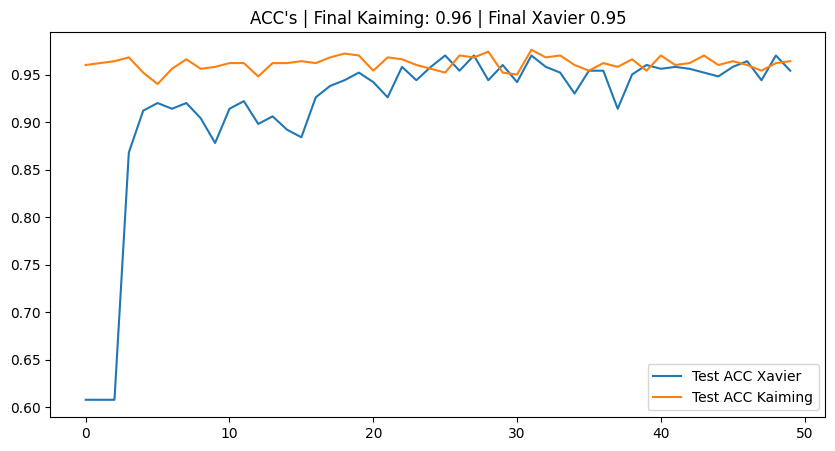

In [296]:
# plt.plot(xavier_train_maes, label = 'Train Xavier')
# plt.plot(kaiming_train_maes, label = 'Train Kaiming')
plt.figure(figsize = (10, 5))
plt.plot(xavier_test_accs, label = 'Test ACC Xavier')
plt.plot(kaiming_test_accs, label = 'Test ACC Kaiming')
plt.title(f'ACC\'s | Final Kaiming: {kaiming_test_accs[-1]:.2f} | Final Xavier {xavier_test_accs[-1]:.2f}')
plt.legend()
plt.show()

## Conclusion

Both Xavier and Kaiming gave similar performance because the network and data weren’t complex enough to fully expose their differences.
While Xavier is theoretically better suited for tanh/sigmoid activations (it keeps activations from vanishing or exploding), Kaiming can still perform well when gradients stay stable — for example, in moderately deep networks or data without sharp nonlinear boundaries.
In this case, the model wasn’t deep or sensitive enough for Xavier’s advantages to matter, so both initializations converged to similar accuracy.